# Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import svm, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVR

# Class Setup

In [2]:
class model():

    def __init__(self):
        self.r2_oos     = object()
        self.r2_is      = object()
        self.predictors = object()
        self.summary    = object()
        self.model      = object()
        self.fitted_model = object()
        self.X_train    = object()
        self.y_train    = object()
        self.X_test     = object()
        self.y_test     = object()
        self.pred       = object()

# Data

In [3]:
df = pd.DataFrame(np.load(r'../data/master_prepared.npy', allow_pickle=True))
cols = np.load(r'../data/columns_prepared.npy', allow_pickle=True)
df.columns = cols

In [4]:
# Market Value
df['mv_^0.5'] = df['mv'] ** 0.5

# Book to Market Value
df['bvtmv_^2'] = df['bvtmv'] ** 2
df['bvtmv_^3'] = df['bvtmv'] ** 3

# Operating Margin
df['opmarg_^2'] = df['opmarg'] ** 2
df['opmarg_^3'] = df['opmarg'] ** 3

# Free cash flow
df['fcf_^2'] = df['fcf'] ** 2
df['fcf_^3'] = df['fcf'] ** 3

# Return on invested capital
df['roic_^2'] = df['roic'] ** 2
df['roic_^3'] = df['roic'] ** 3

# Volatility
df['std_12m_^2'] = df['std_12m'] ** 2
df['std_12m_^3'] = df['std_12m'] ** 3

# Return
df['ret_12m_^2'] = df['ret_12m'] ** 2
df['ret_12m_^3'] = df['ret_12m'] ** 3

# Dividend yield
df['dy_^2'] = df['dy'] ** 2
df['dy_^3'] = df['dy'] ** 3

# Beta
df['beta_^2'] = df['beta'] ** 2
df['beta_^3'] = df['beta'] ** 3

# Shares Outstanding
df['so_^2'] = df['so'] ** 2
df['so_^3'] = df['so'] ** 3


In [5]:
df['mv_bvtmv'] = df['bvtmv'] / df['mv']

df['ret12m_bvtmv'] = df['ret_12m'] * df['mv']

In [6]:
df['mom_3m12m'] = df['ret_3m'] - df['ret_12m']
df['mom_12m36m'] = df['ret_12m'] - df['ret_36m']

In [7]:
drop_cols = [
    'date',
    'eligible',
    'companyid', 
    'ret_1f1',
    'ret_1f3',
    'ret_1f6',
    'ret_1f12',
    'retxs_1f1',
    'retxs_1f3',
    'retxs_1f6',
    'retxs_1f12'
]

y_col = 'retxs_1f1'

# X cols are the independent variables
x_cols = [i for i in list(df.columns) if i not in drop_cols]

# Only use eligible data
df_eligible = df[df['eligible']==1]
X = df_eligible[x_cols].astype('float64')
y = df_eligible[y_col].astype('float64')


In [8]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(how='any', inplace=True)
y = y.loc[X.index]


In [11]:
def prepare_data(start_index, train_range):

    # Dates
    global dates
    dates = df['date'].unique()
    train_dates = dates[start_index:start_index+train_range+1]
    test_dates = dates[start_index+train_range+1]

    # Training Data
    X_train = X[df_eligible['date'].isin(train_dates)].astype('float64')
    X_train = sm.add_constant(X_train)
    y_train = y[df_eligible['date'].isin(train_dates)].astype('float64')

    # Test Data
    X_test = X[df_eligible['date']==test_dates].astype('float64')
    X_test.insert(0, 'const', 1)
    y_test = y[df_eligible['date']==test_dates].astype('float64')
        
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = prepare_data(60, 36)

print("Input Shapes")
print("============")
print('X_train: ', X_train.values.shape)
print('y_train: ', y_train.values.shape)
print('X_test:  ', X_test.values.shape)
print('y_test:  ', y_test.values.shape)

Input Shapes
X_train:  (25712, 78)
y_train:  (25712,)
X_test:   (668, 78)
y_test:   (668,)


# Models

## *Linear Regression*

In [12]:
class LinearReg_sm(model):
    
    def fit_model(self, X_train, y_train):

        predictors = [
            'mv',
            'bvtmv',
            'retxs_12m',
            'std_12m',
            'fcf',
            'roic',
            'dy',
            'beta',
            'mom_3m12m',
            'mom_12m36m'
        ]
        self.predictors = predictors
        self.X_train = X_train[predictors]
        self.y_train = y_train

        model = sm.OLS(y_train, X_train[predictors]).fit()
        self.model = model
        self.summary = model.summary()
    
    def test_model(self, X_test, y_test):
        self.X_test = X_test[self.predictors]
        self.y_test = y_test
        pred = self.model.predict(self.X_test)
        self.r2_oos  = r2_score(y_test, pred)
        self.r2_is   = r2_score(self.y_train, self.model.predict(self.X_train))


LR = LinearReg_sm()
LR.fit_model(X_train, y_train)
LR.test_model(X_test, y_test)

print("Linear       ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[LR.predictors], y=y, scoring='r2', cv=10)))


# print(LR.r2_oos)
print(LR.summary)

Linear        -0.01387433115807366
                                 OLS Regression Results                                
Dep. Variable:              retxs_1f1   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              271.3
Date:                Wed, 12 Feb 2020   Prob (F-statistic):                        0.00
Time:                        18:06:57   Log-Likelihood:                          14034.
No. Observations:               25712   AIC:                                 -2.805e+04
Df Residuals:                   25702   BIC:                                 -2.797e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------

## *Polynomial Regression*

In [13]:
class PolynomialReg_sm(model):

    def fit_model(self, X_train, y_train):
        
        # Same as linear regression but with non-linear predictor set (eg. X^2 terms)
        predictors = [
            'bvtmv','bvtmv_^2','bvtmv_^3', 
            'ret_12m','ret_12m_^2','ret_12m_^3', 
            'std_12m','std_12m_^2','std_12m_^3',
            'fcf','fcf_^2','fcf_^3', 
            'mv','mv_^0.5', 
            'roic','roic_^2','roic_^3', 
            'dy','dy_^2','dy_^3', 
            'beta','beta_^2','beta_^3', 
            'so', 'so_^2'
        ]
        
        self.X_train = X_train[predictors]
        self.y_train = y_train
        
        self.predictors = predictors

        model = sm.OLS(y_train, self.X_train).fit()
        self.model = model
        self.summary = self.model.summary()

    def test_model(self, X_test, y_test):
        self.X_test = X_test[self.predictors]
        self.y_test = y_test
        pred = self.model.predict(self.X_test)
        self.r2_oos  = r2_score(self.y_test, pred)
        self.r2_is   = r2_score(self.y_train, self.model.predict(self.X_train))

PR = PolynomialReg_sm()
PR.fit_model(X_train, y_train)
PR.test_model(X_test, y_test)

print("Polynomial   ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[PR.predictors], y=y, scoring='r2', cv=10)))

# print(PR.r2_oos)
# print(PR.summary)

Polynomial    -0.08315205065935406


## *Regression Tree*

In [116]:
class RegTree(model):
    
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.model = DecisionTreeRegressor(max_depth=self.max_depth)

    def fit_model(self, X_train, y_train):
        
        # Same as linear regression but with non-linear predictor set (eg. X^2 terms)
        predictors = [
            'bvtmv','bvtmv_^2','bvtmv_^3', 
            'ret_12m','ret_12m_^2','ret_12m_^3', 
            'std_12m','std_12m_^2','std_12m_^3',
            'fcf','fcf_^2','fcf_^3', 
            'mv','mv_^0.5', 
            'roic','roic_^2','roic_^3', 
            'dy','dy_^2','dy_^3', 
            'beta','beta_^2','beta_^3', 
        ]
        
        self.X_train = X_train[predictors]
        self.y_train = y_train
        
        self.predictors = predictors

        self.fitted_model = self.model.fit(self.X_train, self.y_train)
        self.summary = "Regression tree has no summary"

    def test_model(self, X_test, y_test):
        self.X_test = X_test[self.predictors]
        self.y_test = y_test
        pred = self.model.predict(self.X_test)
        self.r2_oos  = r2_score(y_test, pred)
        self.r2_is   = r2_score(self.y_train, self.model.predict(self.X_train))


RT = RegTree(max_depth=2)
# RT.fit_model(X_train, y_train)
# RT.test_model(X_test, y_test)

## *Neural Networks*

In [117]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# train_stats = X_train.describe().transpose()

# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_X_train = norm(X_train)
# normed_X_test = norm(X_test)

# def baseline_model():
#     # create model
#     model = keras.Sequential([
#         layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(1)])
#     # Compile model
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model
    
# estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

# model = build_model()
# model.fit(normed_X_train, y_train, epochs=5, verbose=0)
# model.predict(normed_X_test)

# Model Comparison

In [134]:
from sklearn.linear_model import Lasso, Ridge

In [136]:
print("Linear       ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[LR.predictors], y=y, scoring='r2', cv=10)))
print("Tree         ", np.mean(cross_val_score(estimator=DecisionTreeRegressor(max_depth=2), X=X[LR.predictors], y=y, scoring='r2', cv=10)))
print("Polynomial   ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[PR.predictors], y=y, scoring='r2', cv=10)))
print("Lasso        ", np.mean(cross_val_score(estimator=Lasso(alpha=1.5), X=X[LR.predictors], y=y, scoring='r2', cv=10)))
print("Ridge        ", np.mean(cross_val_score(estimator=Ridge(alpha=1.5), X=X[LR.predictors], y=y, scoring='r2', cv=10)))


Linear        -0.0223736473818974
Tree          -0.004909431039938228
Polynomial    -0.0438562653745768
Lasso         -0.014799880349278927
Ridge         -0.022370862002614046


Mean:   model_R2   -0.183868
dtype: float64


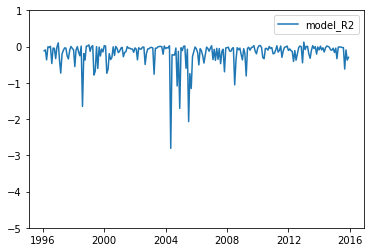

In [122]:
def describe_r2(model, predictors):
    r2_ts = pd.DataFrame(columns=['model_R2'], index=dates)

    for i in range(1,len(dates)-37):
        X_train, y_train, X_test, y_test = prepare_data(i, 36)
        X_train, X_test = X_train[predictors], X_test[predictors]

        try:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            r2_ts['model_R2'].iloc[i] = r2_score(y_test, pred)

        except ValueError as err:
            print(err)

    fig, ax = plt.subplots()
    ax.set_ylim(-5, 1)
    ax.plot(r2_ts)
    plt.legend(r2_ts.columns)
    print("Mean:  ", r2_ts.mean())

describe_r2(model=DecisionTreeRegressor(max_depth=2), predictors=LR.predictors)
